# Uncertainty of Recurrent Neural Network model with dropout at predict time

This notebook demonstrates how dropout may be used at the time of predictions in order to estimate the machine learning model uncertainty. It is important to note that the model uncertainty does not account for the underlying uncertainty in the dataset, but rather the uncertainty provided by the machine learning algorithm itself. Do note that uncertainty analysis is not prioritized in this thesis, as the underlying uncertainty related to the fouling phenomena is largely unknown.

In recurrent networks, a parameter is used to determining whether dropout should be turned on or off at prediction time. If turned off, the model will automatically compute a mean value of predictions. This is typically the most robust approach if uncertainty analysis is not your main objective. However, if dropout is turned on during prediction, we are able to perform individual predictions and explore the randomness of the model. In this case, a number of N predictions are made, from which statistical measurements such as mean and standard deviation can be found.

For dataset *F*, 30min resolution and model type *B* is used. For dataset *G*, both 30min and 10min resolution are used, with model type *A* and model type *C*, respectively.

In [1]:
# %load 4_pred_uncertainty.py
import src.core as mlModule
import src.core_configs as configs

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

model = 'A'

Using TensorFlow backend.


## Required methods

Methods are implemented to plot predictions for a list of LSTM models using dropout at predict time, and to perform model training and predictions for a specified facility. predictive model and dataset resolution.

In [2]:
def plotDropoutPrediction(modelList, predictions, means, stds, targetColumns, df_test, y_test, traintime=None):
    if traintime is not None:
        trainEndStr = [item for sublist in traintime for item in sublist]
    else:
        trainEndStr = None

    for i in range(len(modelList)):
        output_mean = means[i]
        output_std = stds[i]

        for j in range(output_mean.shape[-1]):
            mean = output_mean[:, j]
            std = output_std[:, j]

            upper = np.add(mean, std)
            lower = np.subtract(mean, std)

            fig, ax = plt.subplots(1, 1, figsize=(10,3), dpi=100)
            ax.set_xlabel('Date')
            ax.set_ylabel(mlModule._columnUnits[targetColumns[j]])
            ax.set_title(modelList[i].name + "\nPredictions and targets, " + mlModule._columnDescriptions[targetColumns[j]])
            ax.plot(df_test.iloc[mlModule._maxEnrolWindow:].index, y_test[mlModule._maxEnrolWindow:, j], color="red", alpha=0.5, label="targets")
            ax.plot(df_test.iloc[mlModule._maxEnrolWindow:].index, upper, color="grey", alpha=0.7, label="+/- 1 std bounds")
            ax.plot(df_test.iloc[mlModule._maxEnrolWindow:].index, lower, color="grey", alpha=0.7)
            ax.plot(df_test.iloc[mlModule._maxEnrolWindow:].index, mean, color="blue", alpha=1.0, label="prediction")
            ax.grid(1, axis='y')
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop={'size': 10})
            
            if trainEndStr:
                for i, trainEndString in enumerate(trainEndStr):
                    ax.axvline(x=pd.to_datetime(trainEndString, dayfirst=True), color='black' if i % 2 == 0 else 'blue', label='start training' if i % 2 == 0 else 'end training')

            plt.show()

In [3]:
def performDropoutPrediction(facility, model, resolution, lookback=12, retrain=False):
    filename, columns, irrelevantColumns, targetColumns, traintime, testtime, columnOrder = configs.getConfig(facility, model, resolution)

    df = mlModule.initDataframe(filename, columns, irrelevantColumns)
    df_train, df_test = mlModule.getTestTrainSplit(traintime, testtime)
    X_train, y_train, X_test, y_test = mlModule.getFeatureTargetSplit(targetColumns)

    lstm = mlModule.LSTM('LSTMs 1x128 d0.2 mod'+model, layers=[128], training=True, dropout=0.2, recurrentDropout=0.2, enrolWindow=lookback)
    gru = mlModule.GRU('GRUs 1x128 d0.2 mod'+model, layers=[128], training=True, dropout=0.2, recurrentDropout=0.2, enrolWindow=lookback)
    
    modelList = [
        lstm,
        gru,
    ]

    mlModule.initModels(modelList)
    mlModule.trainModels(retrain)

    predictions, means, stds = mlModule.predictWithModelsUsingDropout(numberOfPredictions=30)
    plotDropoutPrediction(modelList, predictions, means, stds, targetColumns, df_test, y_test, traintime)

# Facility F, model A, 30min

Columns before removal: 
Col. 0 : FYN0111 - Process Flow Rate
Col. 1 : TT0102_MA_Y - Process Inlet Temperature A
Col. 2 : TIC0101_CA_YX - Process Outlet Temperature A
Col. 3 : TT0104_MA_Y - Process Inlet Temperature B
Col. 4 : TIC0103_CA_YX - Process Outlet Temperature B
Col. 5 : TT0106_MA_Y - Process Inlet Temperature C
Col. 6 : TIC0105_CA_YX - Process Outlet Temperature C
Col. 7 : PDT0108_MA_Y - Process A Pressure Difference
Col. 8 : PDT0119_MA_Y - Process B Pressure Difference
Col. 9 : PDT0118_MA_Y - Process C Pressure Difference
Col. 10 : PIC0104_CA_YX - Separator Inlet Pressure
Col. 11 : TIC0425_CA_YX - Coolant Inlet Temperature
Col. 12 : TT0651_MA_Y - Coolant Outlet Temperature A
Col. 13 : TT0652_MA_Y - Coolant Outlet Temperature B
Col. 14 : TT0653_MA_Y - Coolant Outlet Temperature C
Col. 15 : TIC0101_CA_Y - Coolant Valve Opening A
Col. 16 : TIC0103_CA_Y - Coolant Valve Opening B
Col. 17 : TIC0105_CA_Y - Coolant Valve Opening C

Columns after removal: 
Col. 0 : FYN0111 - Process 

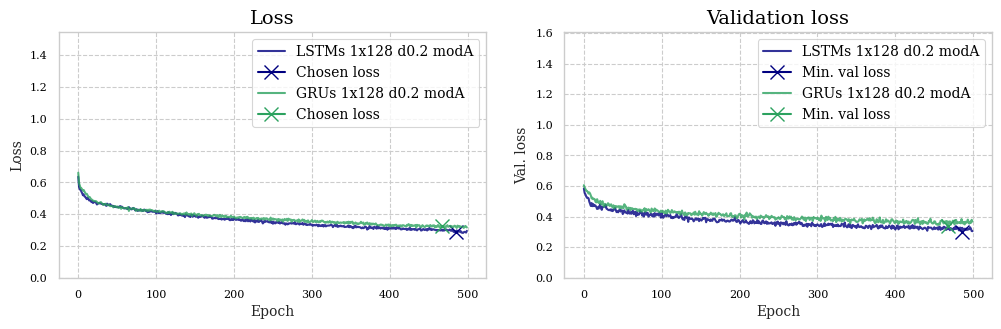

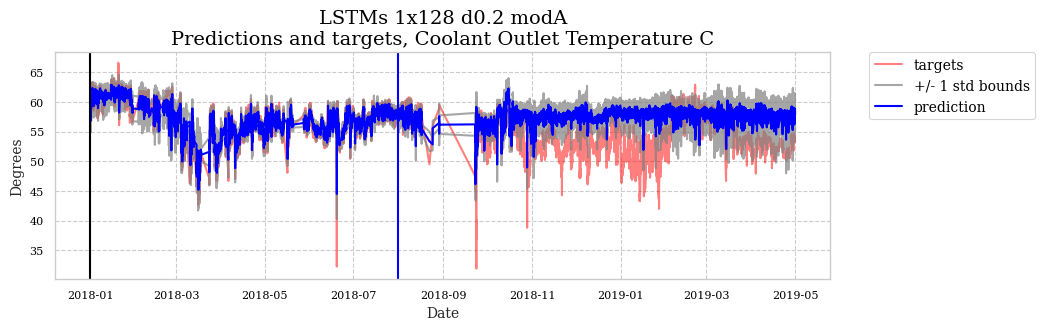

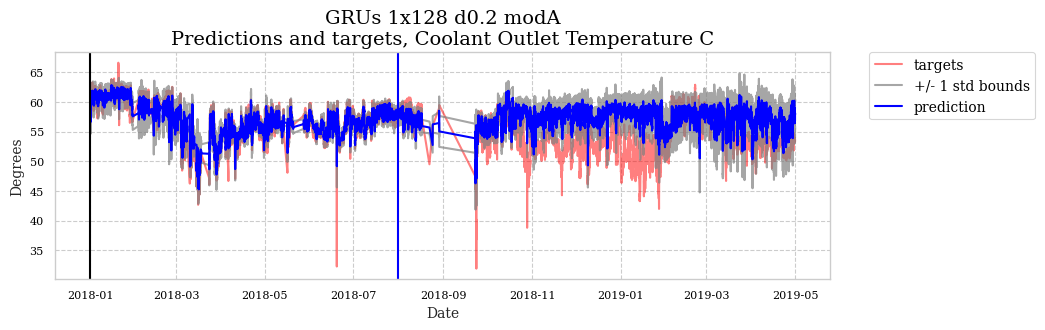

In [4]:
performDropoutPrediction('F', model, '30min', 12, retrain=False)

## Discussion, facility F, model A, 30min

In [5]:
mlModule.reset()

# Facility G, model A, 30min

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : TI0066 - Process Outlet Temperature
Col. 1 : TZI0012 - Process Inlet Temperature
Col. 2 : FI0010 - Process Flow Rate
Col. 3 : TT0025 - Coolant Inlet Temperature
Col. 4 : TT0026 - Coolant Outlet Temperature

Finding data between 2019-04-24 00:00:00 and 2019-08-01 00:00:00
Found 4232 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model LSTMs 1x128 d0.2 modA was loaded from file
Model GRUs 1x128 d0.2 modA was loaded from file
+-----------------------+-----------+-------

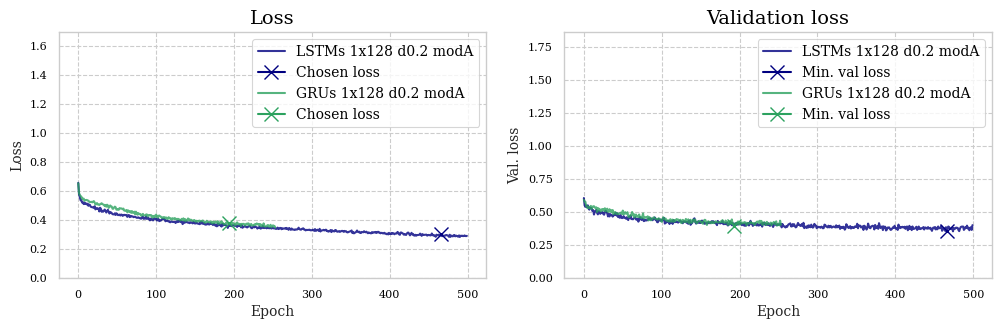

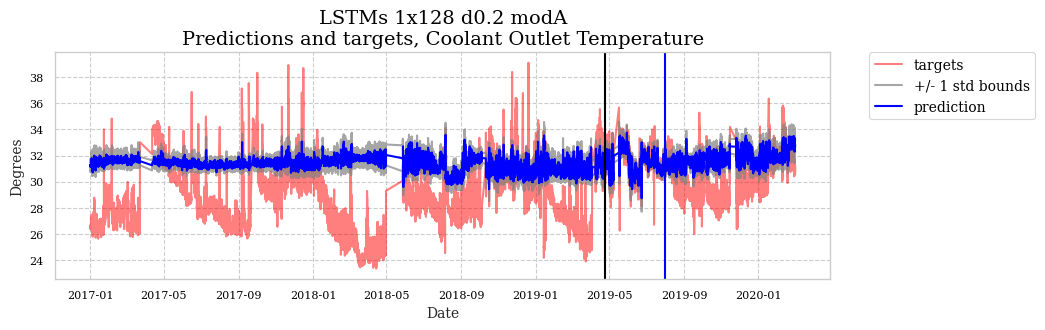

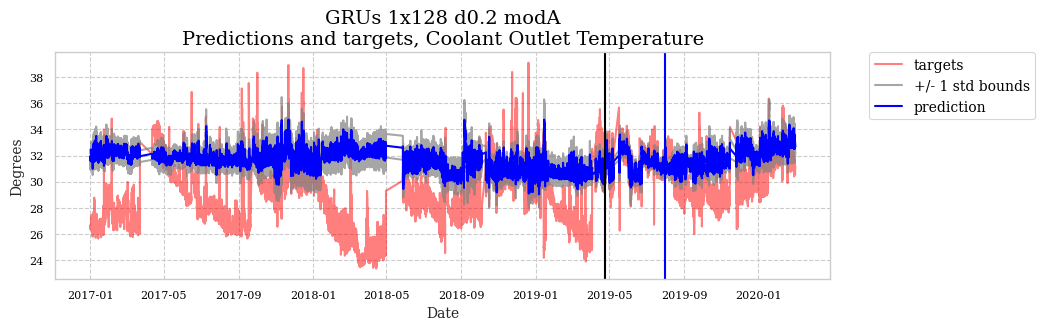

In [6]:
performDropoutPrediction('G', model, '30min', 12, retrain=False)

## Discussion, facility G, model A, 30min

In [7]:
mlModule.reset()

# Facility G, model A, 10min

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : TI0066 - Process Outlet Temperature
Col. 1 : TZI0012 - Process Inlet Temperature
Col. 2 : FI0010 - Process Flow Rate
Col. 3 : TT0025 - Coolant Inlet Temperature
Col. 4 : TT0026 - Coolant Outlet Temperature

Finding data between 2019-04-24 00:00:00 and 2019-08-01 00:00:00
Found 12669 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 146747 rows

Model LSTMs 1x128 d0.2 modA was loaded from file
Model GRUs 1x128 d0.2 modA was loaded from file
+-----------------------+-----------+-----

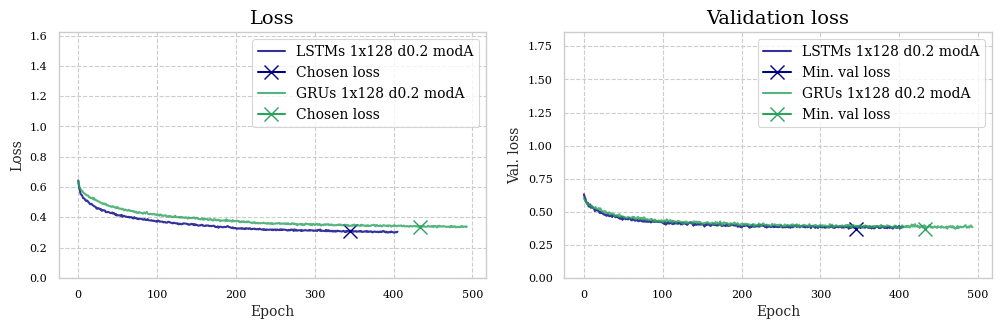

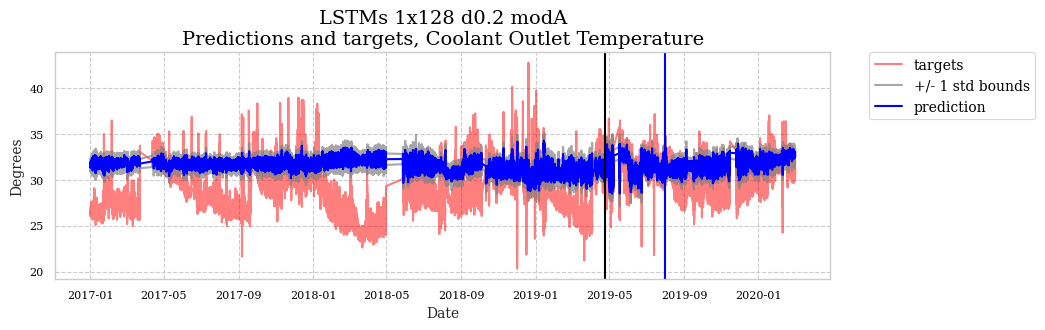

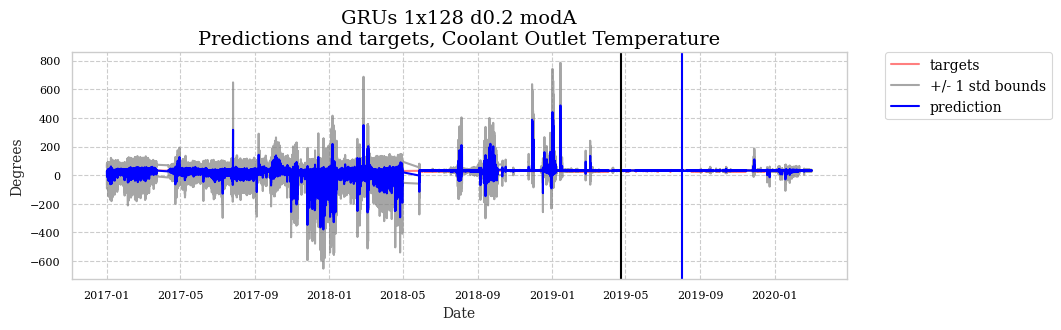

In [8]:
performDropoutPrediction('G', model, '10min', 12*3, retrain=False)

## Discussion, facility G, model A, 10min